### Compute per-bin ratio of allele vs full matrix contacts

In [18]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hicmatrix import HiCMatrix as hm
from pybedtools import BedTool
from utilities import readDiffTAD

In [19]:
cells = ['GM12878', 'IMR90', 'H1hESC']
chroms = [f'chr{c}' for c in range(1, 23)] + ['chrX']

In [20]:
allData = []
allScoredTADs = {}
cellRatio = {}
for cell in cells:
    allTADs = readDiffTAD(cell)
    for chrom in chroms:
        print(cell, chrom)
        if (cell == 'H1hESC') and (chrom == 'chrX'):
            continue
        a1 = hm.hiCMatrix(
            f'../../{cell}/alleleGRCh37/dat/matrix/{chrom}/20000/raw/{cell}_a1-{chrom}-20000-SNPsplit-raw.h5')
        a2 = hm.hiCMatrix(
            f'../../{cell}/alleleGRCh37/dat/matrix/{chrom}/20000/raw/{cell}_a2-{chrom}-20000-SNPsplit-raw.h5')
        full = hm.hiCMatrix(
            f'../../{cell}/fullGRCh37/dat/matrix/{chrom}/20000/raw/{cell}-{chrom}-20000-full-raw.h5')
        
        alleleMat = a1.matrix + a2.matrix
        sumAllele = alleleMat.sum(axis=1)
        sumFull = full.matrix.sum(axis=1)
        
        bed = pd.DataFrame(full.cut_intervals)
        bed['ratio'] = (sumAllele / sumFull).A1
        bed = bed.dropna()
        bed['name'] = '.'
        bed[[0, 1, 2, 'name', 'ratio']].to_csv(
            f'{cell}-{chrom}-ratioScore.bed', index=False, header=False, sep='\t')
        
        bed['cell'] = cell
        allData.append(bed)
        cellRatio[(cell, chrom)] = sumAllele.sum() / sumFull.sum()
        
        for row in allTADs.loc[allTADs['chrom']==chrom].itertuples(index=False):
            indices = full.getRegionBinRange(row.chrom, row.start, row.end)
            fullInteract = full.matrix[indices[0]:indices[1], indices[0]:indices[1]].toarray().mean()
            alleleInteract = alleleMat[indices[0]:indices[1], indices[0]:indices[1]].toarray().mean()
            allScoredTADs[(cell, row.chrom, row.start, row.end, row.type)] = (fullInteract, alleleInteract)
        
allData = pd.concat(allData).rename({0: 'chrom', 1: 'start', 2: 'end'}, axis=1).drop([3, 'name'], axis=1)

GM12878 chr1


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


GM12878 chr2
GM12878 chr3
GM12878 chr4
GM12878 chr5
GM12878 chr6
GM12878 chr7
GM12878 chr8
GM12878 chr9
GM12878 chr10
GM12878 chr11
GM12878 chr12
GM12878 chr13
GM12878 chr14
GM12878 chr15
GM12878 chr16
GM12878 chr17
GM12878 chr18
GM12878 chr19
GM12878 chr20
GM12878 chr21
GM12878 chr22
GM12878 chrX
IMR90 chr1


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


IMR90 chr2
IMR90 chr3
IMR90 chr4
IMR90 chr5
IMR90 chr6


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


IMR90 chr7
IMR90 chr8
IMR90 chr9
IMR90 chr10
IMR90 chr11
IMR90 chr12
IMR90 chr13
IMR90 chr14
IMR90 chr15
IMR90 chr16
IMR90 chr17
IMR90 chr18
IMR90 chr19
IMR90 chr20
IMR90 chr21
IMR90 chr22
IMR90 chrX
H1hESC chr1


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


H1hESC chr2
H1hESC chr3
H1hESC chr4
H1hESC chr5
H1hESC chr6
H1hESC chr7
H1hESC chr8
H1hESC chr9
H1hESC chr10
H1hESC chr11
H1hESC chr12
H1hESC chr13
H1hESC chr14
H1hESC chr15
H1hESC chr16
H1hESC chr17
H1hESC chr18
H1hESC chr19
H1hESC chr20
H1hESC chr21
H1hESC chr22
H1hESC chrX


In [9]:
allData.to_pickle('allAS-ratio.pkl')

In [10]:
(allData.groupby(['cell', 'chrom'])['ratio']
 .mean()
 .reset_index()
 .pivot(columns='cell', index='chrom')
 .to_pickle('cell-ratio.pkl'))

In [21]:
allScoredTADs = pd.DataFrame(allScoredTADs).T.rename({0: 'full', 1: 'allele'}, axis=1)

In [30]:
cols = ['cell', 'chrom', 'start', 'end', 'type', 'full', 'allele']
allScoredTADs2 = pd.DataFrame(allScoredTADs).T.reset_index()
allScoredTADs2.columns = cols

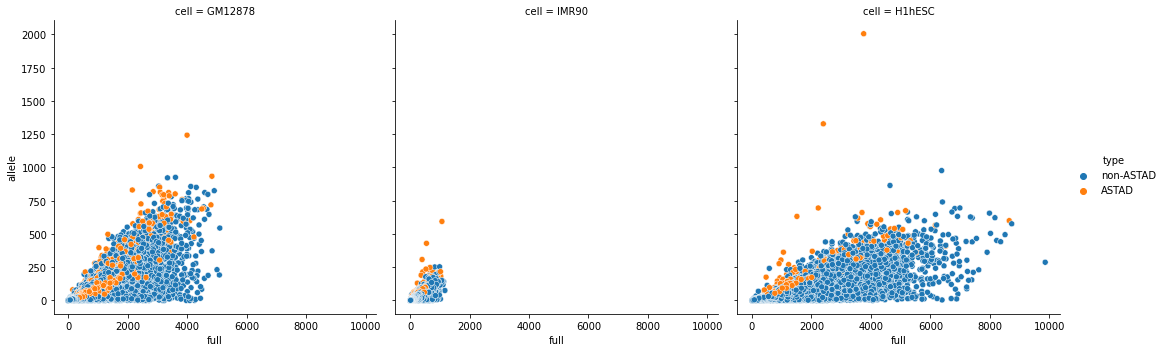

In [36]:
sns.relplot(data=allScoredTADs2, x='full', y='allele', col='cell', hue='type', kind='scatter')